# EDA for `:roffle:` Capstone Project

---

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics \
import precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize, sent_tokenize 
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer


### Utility Functions

In [2]:
def filter_out_references(content):
    '''
        Some comments reference other users, which when converted to a string looks like
        <@....>. Since these are unlikely to be useful for our model, they are removed.
    '''
    updated = list()
    for line in content:
        if not isinstance(line, str):
            continue
        line = re.sub("<[@a-zA-Z0-9]*>", "", line)
        updated.append(line)
    return updated

In [3]:
def generate_vectors_from_content(vectorizer_args, content):
    '''
        Vectorize content to n_grams. Used only by train content, test content will call 
        transform() from the returned vectorizer.
    '''
    vectorizer = CountVectorizer(**vectorizer_args, stop_words='english')
    vectors = vectorizer.fit_transform(content).toarray()
    return (vectors, vectorizer)
    
def generate_tokenized_df(vectors, vectorizer):
    '''
        Tokenized -> Dataframe for both train and test content.
    '''
    # initialize tokenized dataframe and filter out numeric tokens
    tokenized_df = pd.DataFrame(vectors, columns=vectorizer.get_feature_names_out())
    tokenized_df = tokenized_df.filter(regex='^[A-Za-z ]+$', axis=1)
    return tokenized_df

In [4]:
# define a plotter function
def plot_top20_tokens(X):
    total_counts = X.sum()
    sorted_counts = total_counts.sort_values(ascending=False)
    
    plt.figure(figsize=(15,10))
    plt.barh(y= sorted_counts.index[:20], width=sorted_counts[:20])
    plt.gca().invert_yaxis()
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.title('Most common words (train)', fontsize=20)
    plt.show()

In [5]:
def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

In [6]:
def generate_metrics_by_threshold(log_model, X_test, y_test, thresholds):
    # get flag probabilities for each observation in test set
    y_proba = log_model.predict_proba(X_test)[:, 1]

    # get percision, recall, f1, and percent flagged at each threshold
    precs = list()
    recs = list()
    f1s = list()
    perc_flagged = list()

    for threshold in thresholds:
        y_predict_adjusted = np.where(y_proba > threshold, 1, 0)
        prec = precision_score(y_test, y_predict_adjusted)
        recall = recall_score(y_test, y_predict_adjusted)
        f1 = f1_score(y_test, y_predict_adjusted)
        flag = sum(y_predict_adjusted) / len(y_predict_adjusted)

        precs.append(prec)
        recs.append(recall)
        f1s.append(f1)
        perc_flagged.append(flag)
    
    return [precs, recs, f1s, perc_flagged]


In [7]:
def plot_threshold_metrics(precision, recall, f1, perc_flagged, thresholds):
    plt.figure(figsize=(15,10))
    plt.plot(thresholds, precision, marker='o')
    plt.plot(thresholds, recall, marker='o')
    plt.plot(thresholds, f1, marker='o')
    plt.plot(thresholds, perc_flagged, marker='o')
    plt.title('Precision, Recall, F1 Score, and Percent Flagged by Threshold', fontsize=20)
    plt.xlabel('Threshold (%)', fontsize=16)
    plt.ylabel('Metric (%)', fontsize=16)
    plt.legend(labels=['precision', 'recall', 'f1', 'percent flagged'], prop={'size': 16})
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    print('Max precision: {:.2f} @ threshold {:.2f}'.format(max(precision), thresholds[argmax(precision)]))
    print('Max recall: {:.2f} @ threshold {:.2f}'.format(max(recall), thresholds[argmax(recall)]))
    print('Max f1: {:.2f} @ threshold {:.2f}'.format(max(f1), thresholds[argmax(f1)]))

In [8]:
# define a reusable function that converts tokenized dataframes to stemmed ones
def token_stemmer(X):
    print('TOKEN COUNT BEFORE STEMMING:', X.shape[1])
    # instantiate stemmer
    stemmer = nltk.stem.PorterStemmer()
    
    # argument passed by reference, create a copy of X
    X_temp = X.copy()

    # get tokens
    tokens = X_temp.columns
    
    # stem tokens
    tokens_stemmed = [stemmer.stem(word) for word in tokens]
    
    # reassign columns to stemmed tokens
    X_temp.columns = tokens_stemmed

    # group by common stemmed tokens and aggregate by sum
    X_transposed = X_temp.T
    X_transposed.index = X_transposed.index.set_names('token')
    X_transposed = X_transposed.groupby('token').sum()
    
    X_final = X_transposed.T
    print('TOKEN COUNT AFTER STEMMING:', X_final.shape[1])
    return X_final
    

In [9]:
def build_MLE_model(corpus, n_gram):
    train_data, padded_sents = padded_everygram_pipeline(n_gram, corpus)    
    mle_model = MLE(n_gram)
    mle_model.fit(train_data, padded_sents)
    return mle_model 


In [10]:
def generate_new_content(model, n_words):
    detokenize = TreebankWordDetokenizer().detokenize
    
    content = list()
    for token in model.generate(n_words):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [11]:
def generate_roc(X, y):
    y_proba = log_model.predict_proba(X)[:,1]

    # destructure roc_curve values
    fprs, tprs, thresholds = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)

    plt.figure()
    plt.plot(fprs, tprs, color='darkorange',
             lw=2, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for Funny Comment Prediciton')
    plt.legend(loc="best")
    plt.show()

    print(f'Area under curve (AUC):{roc_auc}')
    print()


### Analysis

In [12]:
df = pd.read_csv('~/brainstation/capstone/roffle/eda/eda.csv')
df = df.drop(df.columns[0], axis=1)
display(df)

,id,discord_id,joy,rofl,has_funny_emoji,content
0,66574,1032312745892253746,0,0,0,man he is giving me heart attack
1,66575,1030579195782385685,4,0,1,NaN
2,66576,1030503715192455188,0,0,0,I'll take that liberating one min hahah 🥲
3,66577,1030503514855723058,0,0,0,<@1027994547655020635>
4,66578,1030503491589914665,0,0,0,as Elie said your freedom just last for 1 Min
...,...,...,...,...,...,...
22193,88767,899665743011008562,0,0,0,It isn't tho cody
22194,88768,899665720210755594,0,0,0,"Yeah, I was worried it was EST"
22195,88769,899663504573874236,0,0,0,"think that time is my local time btw (cst), ch..."
22196,88770,899658469139968001,0,0,0,😩


In [13]:
# Determine how our target variable is distributed
counts = df['has_funny_emoji'].value_counts()
perc_total = [count / df.shape[0] * 100 for count in counts]
perc_total

[97.5808631408235, 2.4191368591765023]

We see from the cell above that only 2% of the data is comprised of Discord messages that received a laughing face reaction.  

To prevent class imbalance, we will first try different models before resorting to up/downscaling the data.

## Data Cleaning

Since we have some funny messages that contain images or gifs, we will simplify our efforts by considering _only_ text messages.

In [14]:
# filter discord messages with text content
text_mask =(df['content'].notnull()) & \
        (~df['content'].str.startswith('https', na=False))
        
                                            
text_df = df[text_mask]

removed_refs = filter_out_references(text_df['content'])
text_df['content'] = removed_refs

/tmp/ipykernel_5651/2879284680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['content'] = removed_refs


In [15]:
# remove rows with empty content after replacing user references with empty strings
non_empty_mask = (text_df['content'] != "")
text_df = text_df[non_empty_mask]
text_df

,id,discord_id,joy,rofl,has_funny_emoji,content
0,66574,1032312745892253746,0,0,0,man he is giving me heart attack
2,66576,1030503715192455188,0,0,0,I'll take that liberating one min hahah 🥲
4,66578,1030503491589914665,0,0,0,as Elie said your freedom just last for 1 Min
5,66579,1030503331292008628,0,1,1,We have a project due on Monday though 🥲🥲🥲🥲
8,66582,1030161204334829669,0,0,0,delivery time hahah
...,...,...,...,...,...,...
22192,88766,899665751655448586,0,0,0,you good
22193,88767,899665743011008562,0,0,0,It isn't tho cody
22194,88768,899665720210755594,0,0,0,"Yeah, I was worried it was EST"
22195,88769,899663504573874236,0,0,0,"think that time is my local time btw (cst), ch..."


Let's get an idea of what proportion of these discord messages had a funny emoji response.

In [39]:
funny_count = sum(text_df['has_funny_emoji'])
total = text_df.shape[0]
percent_funny = funny_count / total * 100

print('{:.2f}% of all comments received a funny emoji.'.format(percent_funny))

2.06% of all comments received a funny emoji.


## Tokenization

We will create a function we can re-use to generate tokenized train and test dataframes.

Next we use our function to generate train and test tokenized dataframes, which we will use later to generate a model.

In [16]:
X = text_df['content']
y = text_df['has_funny_emoji']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2, stratify=y)

# try different n gram ranges
max_n_gram = range(1, 5)
vectorizer_args = {
    "min_df": 3,
    "ngram_range": (1,3)
}

# fit_transform vectorizer on train data, then use the vectorizer to  transform test data.
train_vector, vectorizer = generate_vectors_from_content(vectorizer_args, X_train)
test_vector = vectorizer.transform(X_test).toarray()

# convert to dataframes  
X_train_tokenized = generate_tokenized_df(train_vector, vectorizer)
X_test_tokenized = generate_tokenized_df(test_vector, vectorizer)


For explorative purposes we will see which tokens are most common in our train set.

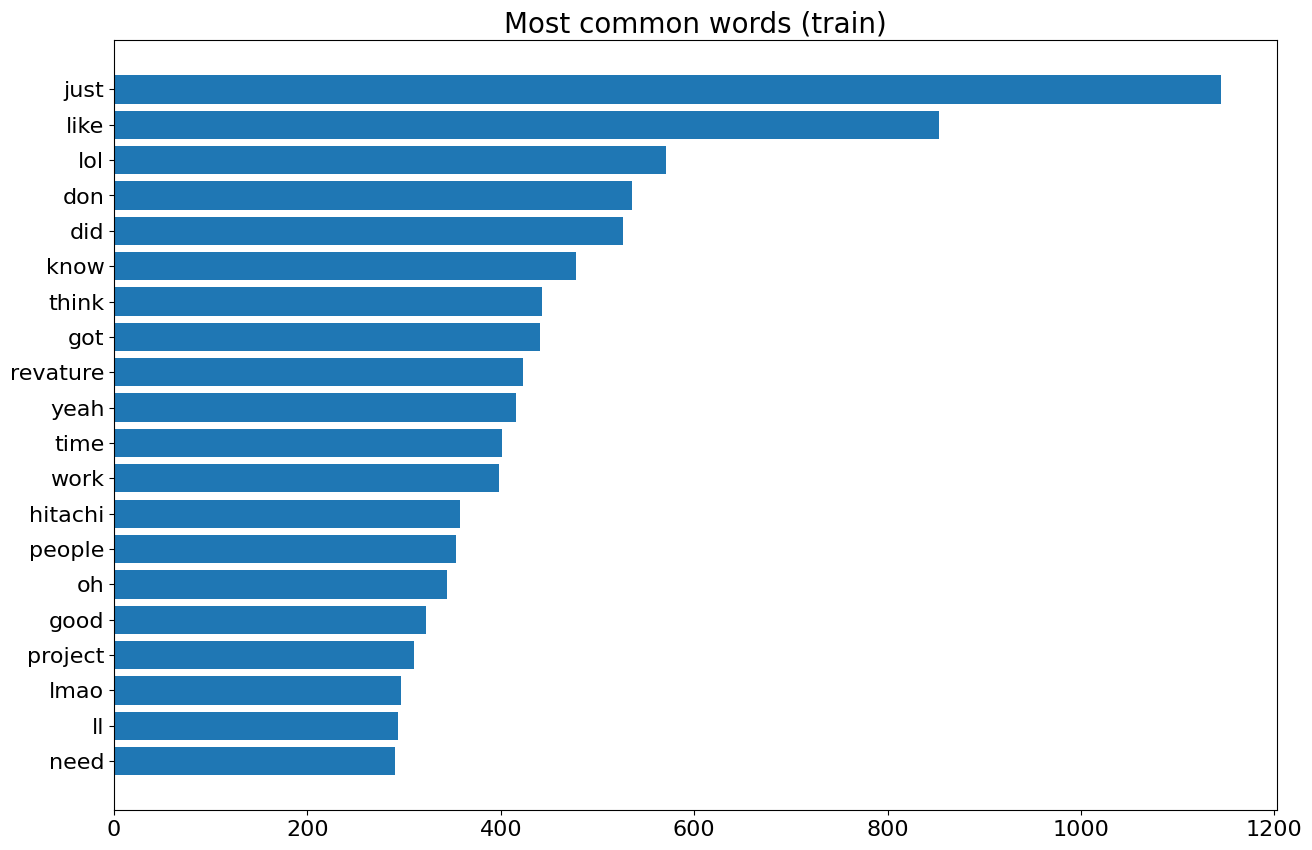

In [17]:
# plot figure
plot_top20_tokens(X_train_tokenized)

Now we will train some models using our tokenized dataframes. Our classes are still imbalanced, so we expect a high accuracy but low precision and/or recall.

In [18]:

# Parameterless because features are word counts, so they should not require regularization
log_model = LogisticRegression()

log_model.fit(X_train_tokenized, y_train)

train_score = log_model.score(X_train_tokenized, y_train)
test_score = log_model.score(X_test_tokenized, y_test)

print('Train/test accuracy: {:.2f}/{:.2f}'.format(train_score, test_score))

Train/test accuracy: 0.98/0.98


In [19]:
y_predict = log_model.predict(X_test_tokenized)
report = classification_report(y_test, y_predict)
percent_flagged = (sum(y_predict) / len(y_predict)) * 100
percent_pos = (sum(y_test) / len(y_predict) * 100)
print('Percent flagged: {:.2f}%'.format(percent_flagged))
print('Percent positive: {:.2f}%\n'.format(percent_pos))
print(report)

Percent flagged: 0.05%
Percent positive: 2.07%

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4166
           1       0.00      0.00      0.00        88

    accuracy                           0.98      4254
   macro avg       0.49      0.50      0.49      4254
weighted avg       0.96      0.98      0.97      4254



Our model flagged only 0.05% of our test data when over 2% of it was actually positive. The true positive count will be low (probably zero) given how few observations were flagged, which will in turn give us low precision and recall values.

To increase the permissibility of our model, we will try lowering the probability threshold.

Original percision/recall: 0.00 / 0.00 / 0.00
Max precision: 0.10 @ threshold 0.25
Max recall: 0.82 @ threshold 0.01
Max f1: 0.09 @ threshold 0.04


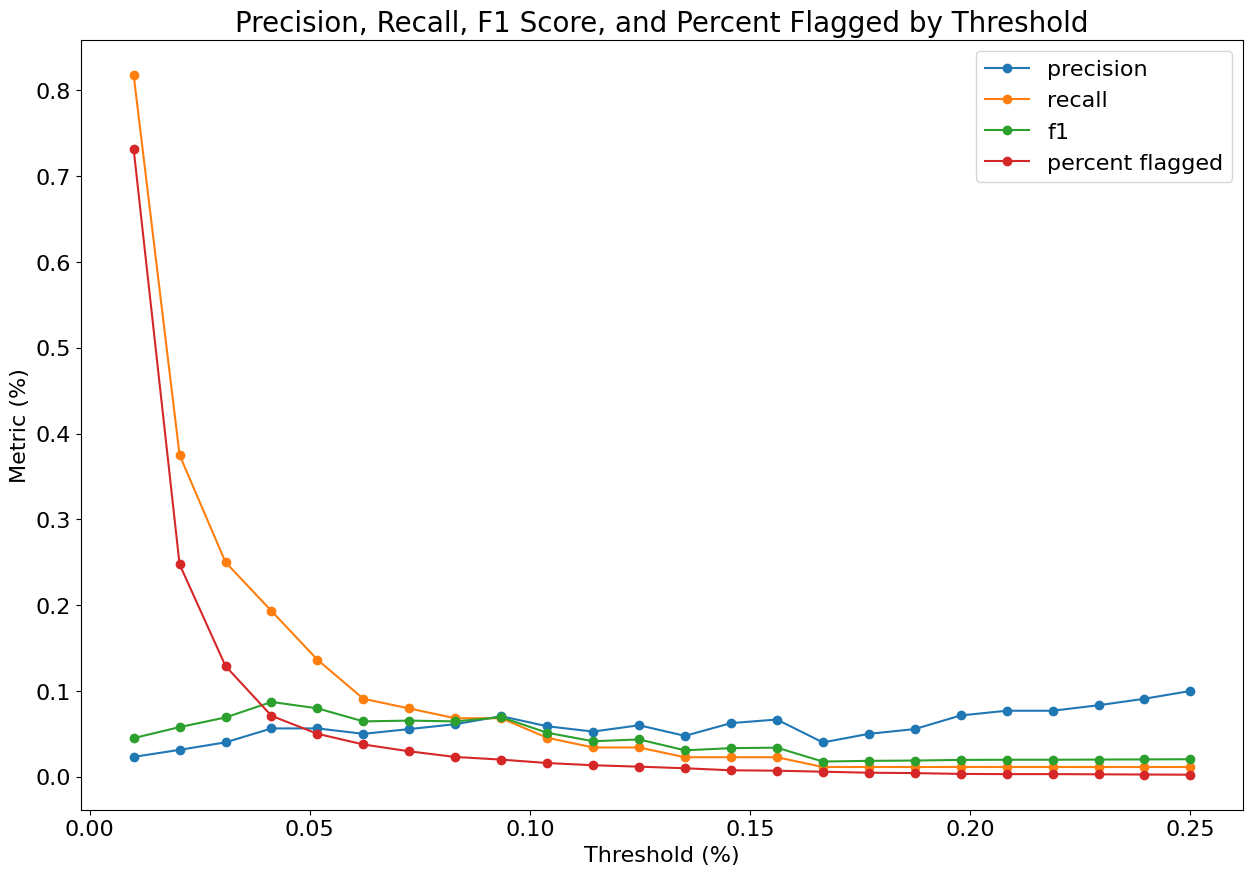

In [20]:
# print original precision and recall scores
orig_prec = precision_score(y_test, y_predict)
orig_recall = recall_score(y_test, y_predict)
orig_f1 = f1_score(y_test, y_predict)

thresholds = np.linspace(0.01, 0.25, 24)

precs, recs, f1, perc_flagged = generate_metrics_by_threshold(log_model, X_test_tokenized, y_test, thresholds)

print('Original percision/recall: {:.2f} / {:.2f} / {:.2f}'.format(orig_prec, orig_recall, orig_f1))

# plot 
plot_threshold_metrics(precs, recs, f1, perc_flagged, thresholds)


We see that our model as it stands is suboptimal due to its low precision and recall scores. An optimal model would also have a high enough permissability, as we don't want our app to be too hard a critic and reject a majority of attempts.

## Improving our Model

While we can try different classification models and assess their performance on our existing tokens, a better strategy may be to come up with different token-generation methods so that our "baseline" metrics will be better.

### Stemming and Lemmatizing

We begin by stemming, or reducing a word to its "word stem" by removing "-ing" or "s".

In [21]:
# stem our original train and test tokenized data
X_train_stemmed = token_stemmer(X_train_tokenized)
X_test_stemmed = token_stemmer(X_test_tokenized)

TOKEN COUNT BEFORE STEMMING: 4926
TOKEN COUNT AFTER STEMMING: 4020
TOKEN COUNT BEFORE STEMMING: 4926
TOKEN COUNT AFTER STEMMING: 4020


Stemming reduced our tokens by roughly 250 words.

Max precision: 0.09 @ threshold 0.10
Max recall: 0.75 @ threshold 0.01
Max f1: 0.08 @ threshold 0.10


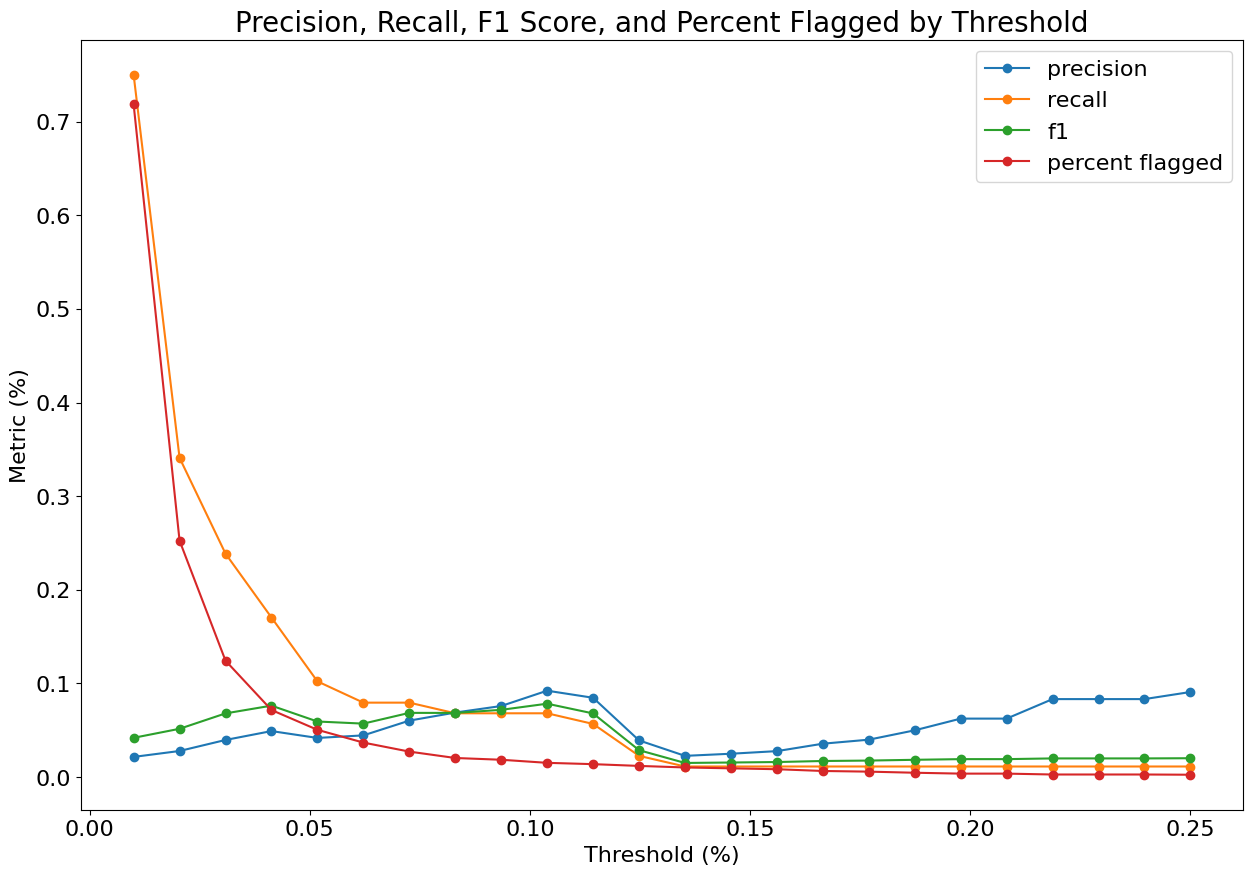

In [22]:
# retry logistic regression model
log_model_stemmed = LogisticRegression()
log_model_stemmed.fit(X_train_stemmed, y_train)
metrics = generate_metrics_by_threshold(log_model_stemmed, X_test_stemmed, y_test, thresholds)

plot_threshold_metrics(*metrics, thresholds)

Our model remains relatively unchanged.

## Text Generation

Our poor model performance may be due to the severe class imbalance between funny and non-funny comments. We will up-sample the funny comments by generating new text.

We need to upsample our train and test samples separately to avoid cross contamination.

In [23]:
train_df = pd.merge(X_train, y_train, left_index=True, right_index=True)
test_df = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [24]:
funny_df_train = train_df[train_df['has_funny_emoji'] == 1].reset_index(drop=True)
funny_df_test = test_df[test_df['has_funny_emoji'] == 1].reset_index(drop=True)


Next we create a`generate_new_content`.

In [25]:
# using NLTK's tokenizer
corpus_train = list(funny_df_train['content'].apply(word_tokenize))
corpus_test = list(funny_df_test['content'].apply(word_tokenize))

`build_MLE_model` will return a model that can generate a list of words that, when combined, will gives us our a single sample of new funny content.

In [26]:
mle_model_train = build_MLE_model(corpus_train, 3)
mle_model_test = build_MLE_model(corpus_test, 3)

`generate_new_content` filters out the delimeters created by the tokenizer and joins the tokens back together.

In [27]:
generate_new_content(mle_model_train, n_words=20)

'hours ...'

We figure by how much we have to upsample.

In [28]:
# find how many new rows are needed for train and test
n_unfunny_train = train_df['has_funny_emoji'].value_counts()[0]
n_upsample_train = n_unfunny_train - (train_df.shape[0] - n_unfunny_train)
print('Train upsample quantity:', n_upsample_train)

Train upsample quantity: 16314


In [29]:
n_unfunny_test = test_df['has_funny_emoji'].value_counts()[0]
n_upsample_test = n_unfunny_test - (test_df.shape[0] - n_unfunny_test)
print('Test upsample quantity:', n_upsample_test)

Test upsample quantity: 4078


Now we generate the content we'll be upsampling with.

In [30]:
# generate new train data
new_content_train = list()

for i in range(n_upsample_train):
    new_content_train.append((generate_new_content(mle_model_train, n_words=20), 1))

In [31]:
new_content_test = list()

for i in range(n_upsample_test):
    new_content_test.append((generate_new_content(mle_model_test, n_words=20), 1))

For some reason there were empty strings that were generated, so we filter those out before merging upsamples to our original dataframes.

In [32]:
# filter out empty content
new_content_train = [content for content in new_content_train if content[0] != '']
new_content_test = [content for content in new_content_test if content[0] != '']

print('Generated train content remaining:', len(new_content_train))
print('Generated test content remaining:', len(new_content_test))


Generated train content remaining: 14476
Generated test content remaining: 3605


Now we merge the upscaled content with our original data.

In [33]:
# convert to dataframe
upsample_df_train = pd.DataFrame(new_content_train, columns = train_df.columns)
upsample_df_test = pd.DataFrame(new_content_test, columns = test_df.columns)


# merge generated df with original df
train_df = train_df.append(upsample_df_train, ignore_index=True)
test_df = test_df.append(upsample_df_test, ignore_index=True)

/tmp/ipykernel_5651/3824618361.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(upsample_df_train, ignore_index=True)
/tmp/ipykernel_5651/3824618361.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(upsample_df_test, ignore_index=True)


In [34]:
display(train_df)
display(test_df)

,content,has_funny_emoji
0,"I'm 5'8"" and weigh 140 lbs.",0
1,It seems like a good thing!,0
2,"It's actually pretty annoying, lol. I spent ov...",0
3,Any of you get picked? They told me they are m...,0
4,So a stigma.,0
...,...,...
31485,that tests nothing...and they still had two le...,1
31486,how am i supposed to let the noodles get wet t...,1
31487,don't have to pay us to and then never did it 😂,1
31488,out something for Hitachi that says what we we...,1


,content,has_funny_emoji
0,that's helpful actually,0
1,😭,0
2,*two*,0
3,they’re training you for the disappointment to...,0
4,THE POWER,0
...,...,...
7854,was awful . Had to ask him to repeat himself 1...,1
7855,DUDE...pee in a cup . freeze it . 1 day shippi...,1
7856,This is not sarcasm . This is not sarcasm . Th...,1
7857,Probably that windmill,1


We'll tokenize these before refitting our models.

In [35]:
X_train = train_df['content']
X_test = test_df['content']
y_train = train_df['has_funny_emoji']
y_test = test_df['has_funny_emoji']


vectorizer_args = {
    "min_df": 3,
    "ngram_range": (1,3)
}

# fit_transform vectorizer on train data, then use the vectorizer to  transform test data.
train_vector, vectorizer = generate_vectors_from_content(vectorizer_args, X_train)
test_vector = vectorizer.transform(X_test).toarray()

# convert to dataframes  
X_train_tokenized = generate_tokenized_df(train_vector, vectorizer)
X_test_tokenized = generate_tokenized_df(test_vector, vectorizer)


Now we'll re-fit our models and see if it improves our scores.

In [36]:
# Parameterless because features are word counts, so they should all be on same scale
log_model = LogisticRegression()

log_model.fit(X_train_tokenized, y_train)

train_score = log_model.score(X_train_tokenized, y_train)
test_score = log_model.score(X_test_tokenized, y_test)

print('Train/test accuracy: {:.2f}/{:.2f}'.format(train_score, test_score))

Train/test accuracy: 0.94/0.55


We have 56% test accuracy, which isn't great but seems more promising than what we had before. Let's take a look at precision, recall, and f1.

In [37]:
from sklearn.metrics import classification_report

y_predict = log_model.predict(X_test_tokenized)
report = classification_report(y_test, y_predict)
percent_flagged = (sum(y_predict) / len(y_predict)) * 100
percent_pos = (sum(y_test) / len(y_predict) * 100)
print('Percent flagged: {:.2f}%'.format(percent_flagged))
print('Percent positive: {:.2f}%\n'.format(percent_pos))
print(report)

Percent flagged: 5.08%
Percent positive: 46.99%

              precision    recall  f1-score   support

           0       0.54      0.97      0.70      4166
           1       0.71      0.08      0.14      3693

    accuracy                           0.55      7859
   macro avg       0.63      0.52      0.42      7859
weighted avg       0.62      0.55      0.43      7859



A low recall is expected because we increased the number of true positives when we upsampled our data but the percent of comments we flagged was only 5%. Given how roughly 50% of our data contains funny content, it makes sense that our precision is at least 50%. We see that we do 20% better at correctly flagging a funny comment than random choice.

An ROC curve may emphasize the last point we made.

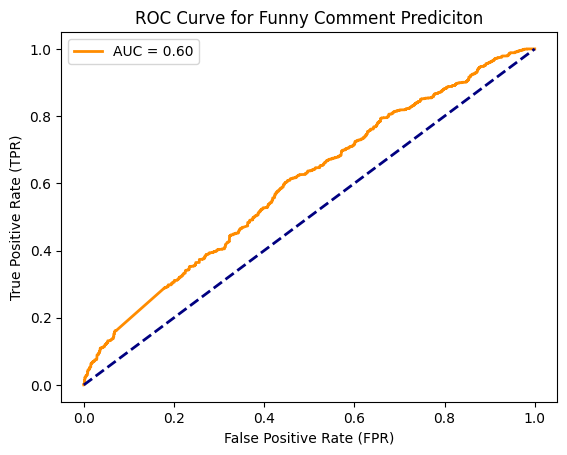

Area under curve (AUC):0.5982424612795887



In [38]:
generate_roc(X_test_tokenized, y_test)

The ROC curve seems to indicate we our model didn't do as well as our precision led us to believe, but is still performing better than a baseline random average.

What if we try lowering the probability threshold as before? We expect the recall to increase but it may also affect our precision negatively.

Max precision: 0.57 @ threshold 0.25
Max recall: 0.90 @ threshold 0.01
Max f1: 0.63 @ threshold 0.01


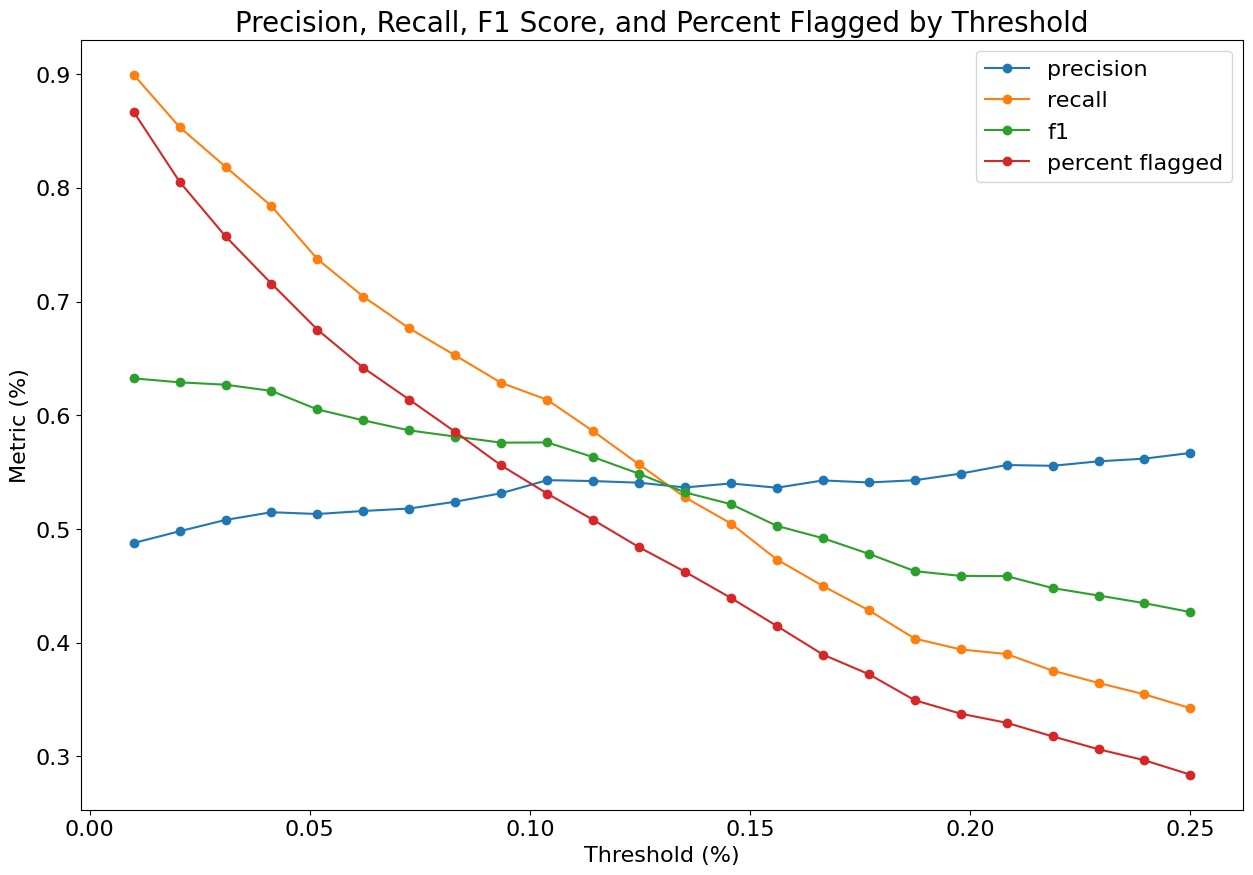

In [42]:
metrics = generate_metrics_by_threshold(log_model, X_test_tokenized, y_test, thresholds)

plot_threshold_metrics(*metrics, thresholds)

As expected, the more lenient we made our model the greater the recall, but our precision dropped to nearly being no better than a baseline.

The utility of this model would depend on its purpose. If we were building an app to predict whether a comment in which a user was _trying_ to be funny is actually funny, we would have to assume the proportion of true positives is much higher than in our original case where only 2% of our data contained true positives. In such a case, we would reduce the probability threshold and see an un-ideal dip in precision.  


However, if we were building something like a Discord bot that would periodically give a comment a funny emoji reaction, we would want the percent flagged to be near 2% (or whatever the proportion of funny to not-funny comments are at the time). As we saw, our model at 50% threshold flagged only 5% of the data but had a relatively high precision. In this case, our model may have some utility.